In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

%matplotlib inline
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
data = pd.read_csv('DATA/c13_9_2_prep.csv')
data.drop(['Unnamed: 0'], axis=1,inplace = True)
data.head()

Wall time: 3.4 s


In [3]:
%%time
data2 = data.copy()
data2['prev_level'] = data2.groupby(['ACC'])['LVL'].shift()
data2['prev_level_diff'] = data2.groupby(['ACC'])['prev_level'].diff()
data2 = data2.dropna()
data2.head()

Wall time: 17.4 s


In [4]:
data2[data2['ACC'] == 152][['LVL', 'prev_level', 'CAMP']]

,LVL,prev_level,CAMP
96741,4,4.0,2
142735,3,4.0,3
187669,4,3.0,4
232108,4,4.0,5
277827,4,4.0,6
328335,3,4.0,7
381846,3,3.0,8
434318,2,3.0,9
488504,4,2.0,10
545095,3,4.0,11


In [11]:
'''def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))'''
def rmsle(y_true,y_pred):
    return accuracy_score(y_true, y_pred)
    

In [12]:
def plot_difference(df1, df2, camp):
    
    grouped = df1.groupby(df1).count()
    grouped2 = df2.groupby(df2).count()
    result = pd.DataFrame(grouped)
    result2 = pd.DataFrame(grouped2)
    
    result.columns = ['count']
    result['lvl'] = result.index
    result['values'] = 'prediction'
    
    result2.columns = ['count']
    result2['lvl'] = result2.index
    result2['values'] = 'actual'
    
    result_r = pd.concat([result, result2])
    
    import seaborn as sns
    sns.set(style="whitegrid")


    # Draw a nested barplot to show survival for class and sex
    g = sns.catplot(x="lvl", y="count", hue="values", data=result_r,
                height=8, kind="bar", palette="muted",  aspect=1.8)
    g.despine(left=True)
    g.set_ylabels(camp)
    
    return 

CAMP 3 - Error 0.63510
CAMP 4 - Error 0.68009
CAMP 5 - Error 0.67381
CAMP 6 - Error 0.58019
CAMP 7 - Error 0.65955
CAMP 8 - Error 0.52994
CAMP 9 - Error 0.70511
CAMP 10 - Error 0.57421
CAMP 11 - Error 0.56225
CAMP 12 - Error 0.68179
CAMP 13 - Error 0.68914
CAMP 14 - Error 0.70125
CAMP 15 - Error 0.70623
Mean Error = 0.64451
Wall time: 3.56 s


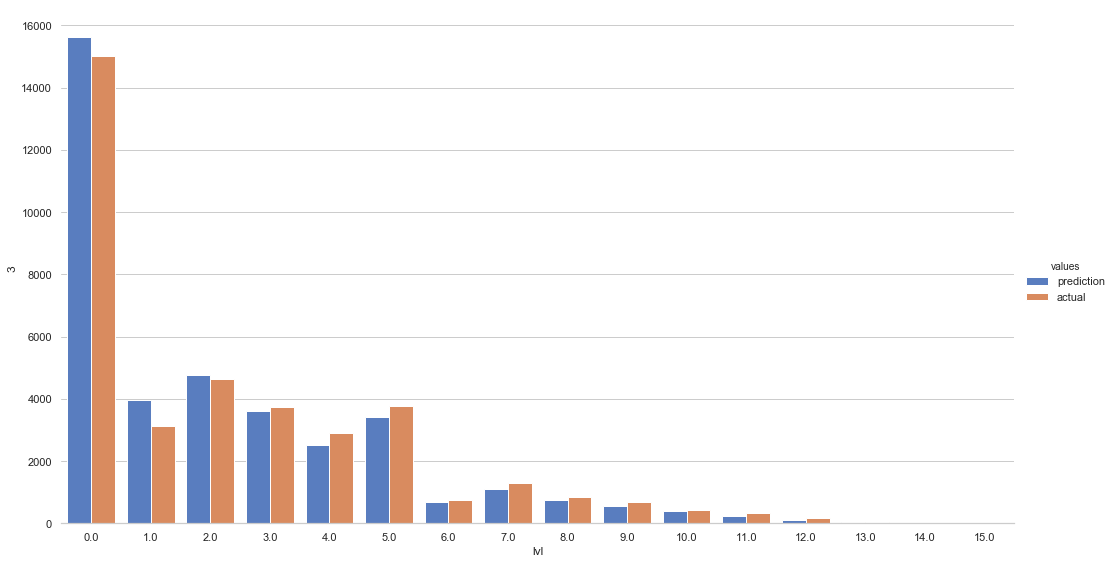

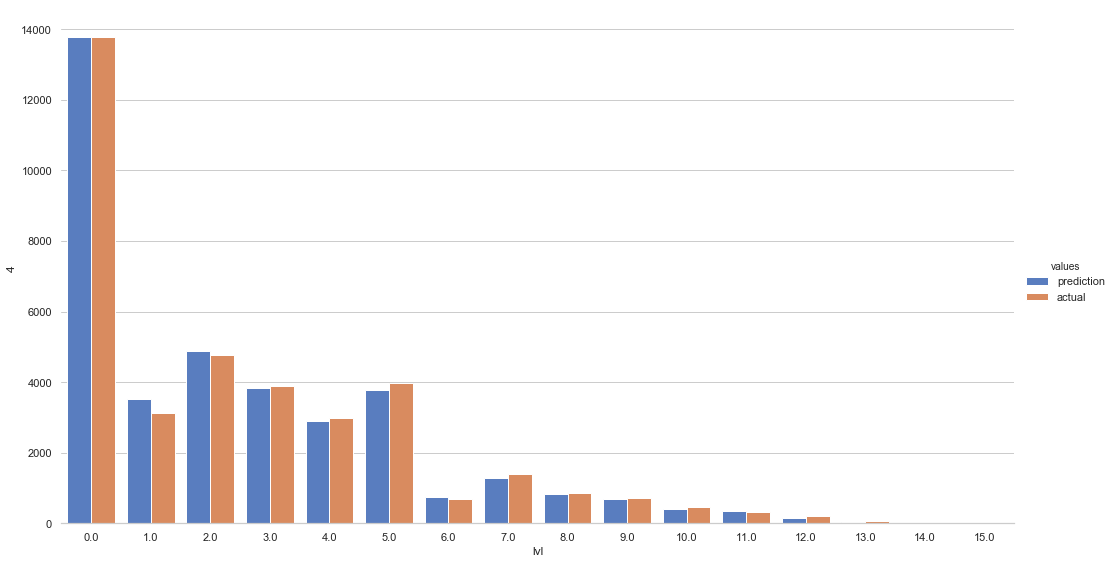

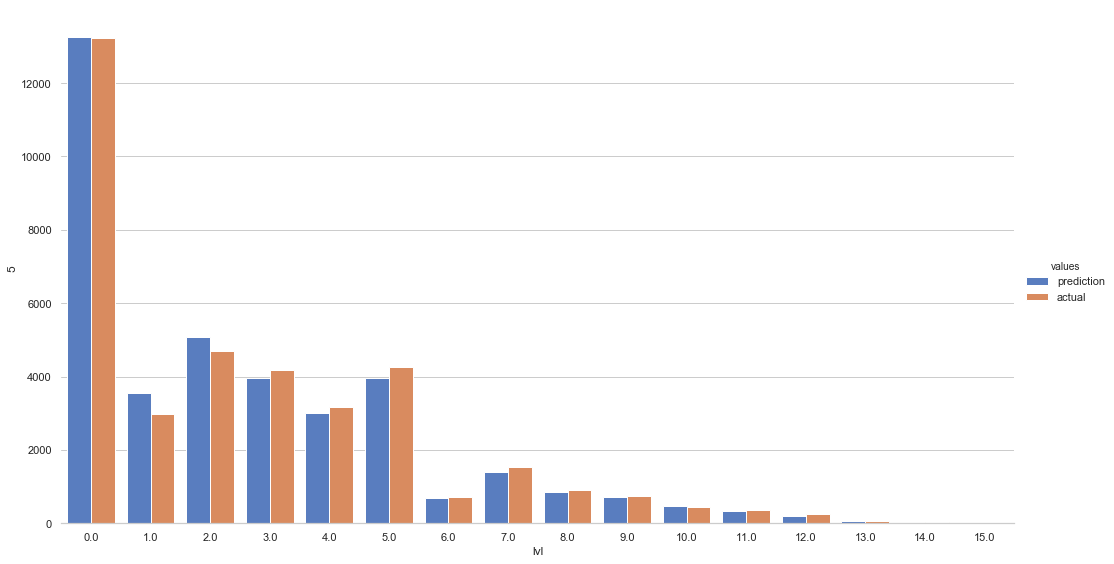

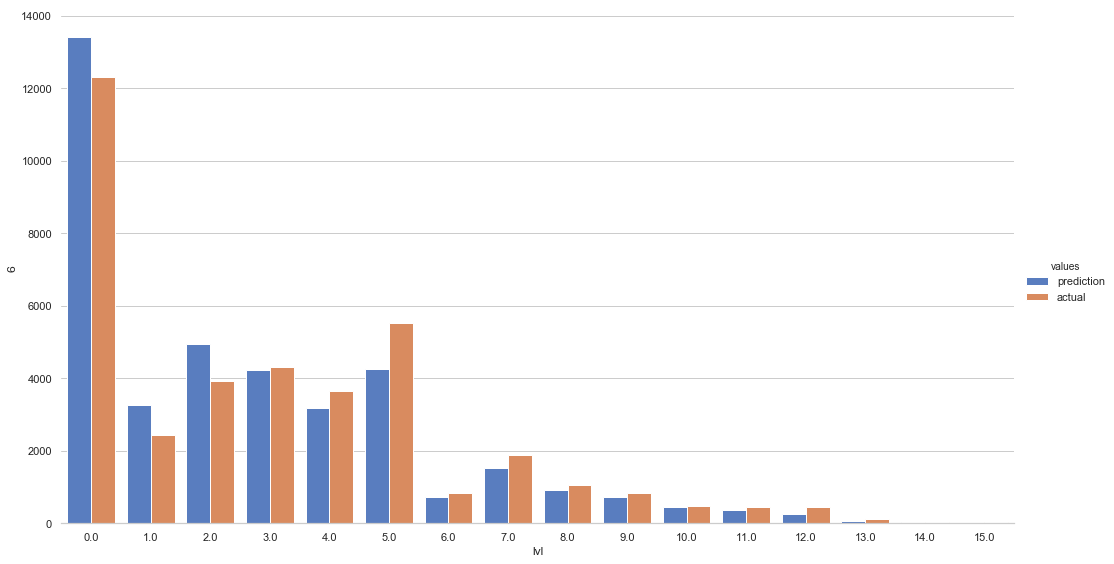

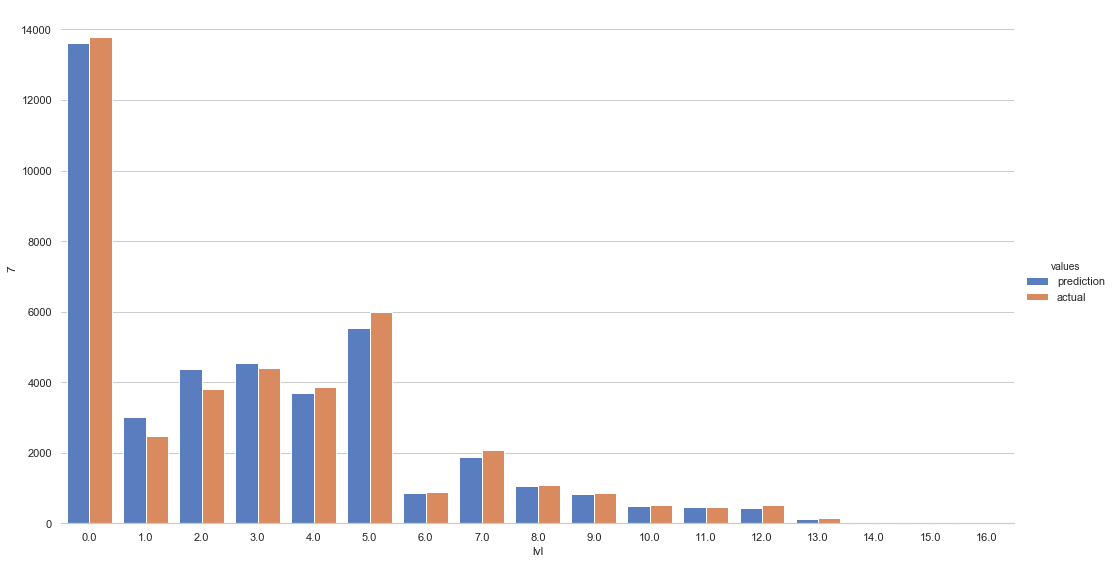

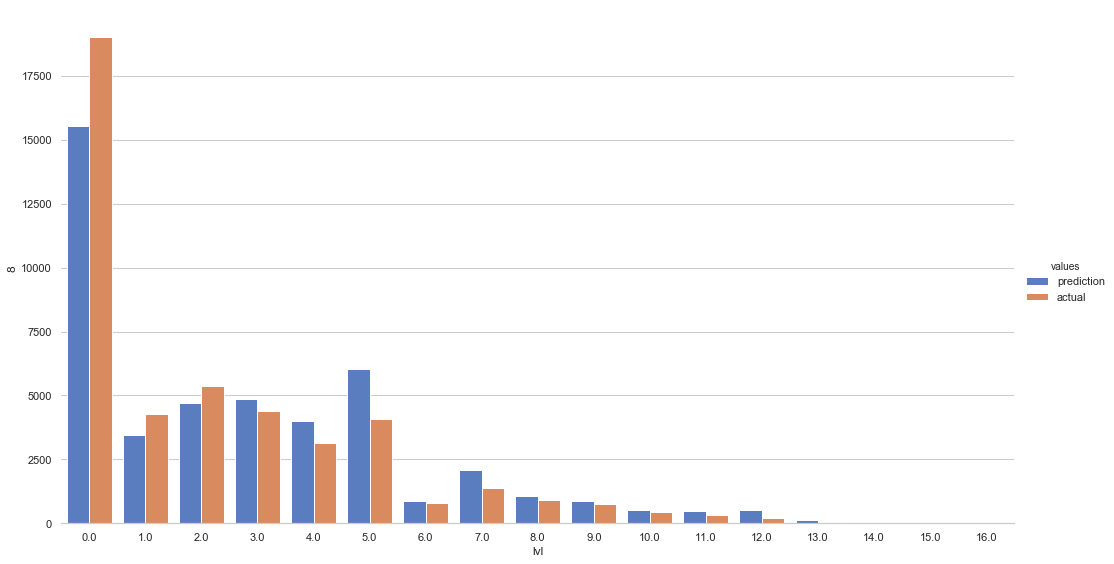

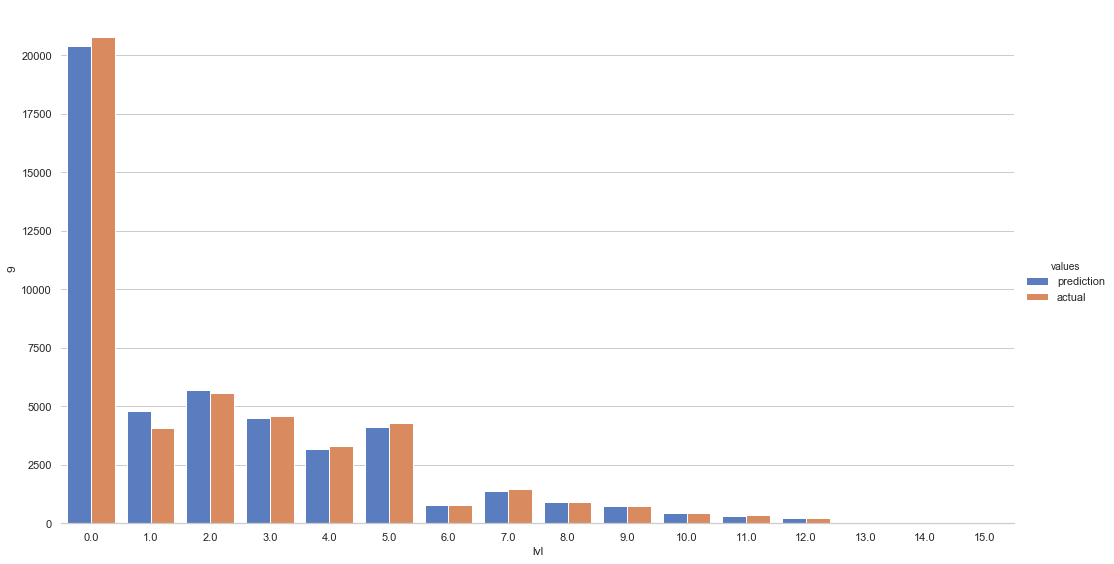

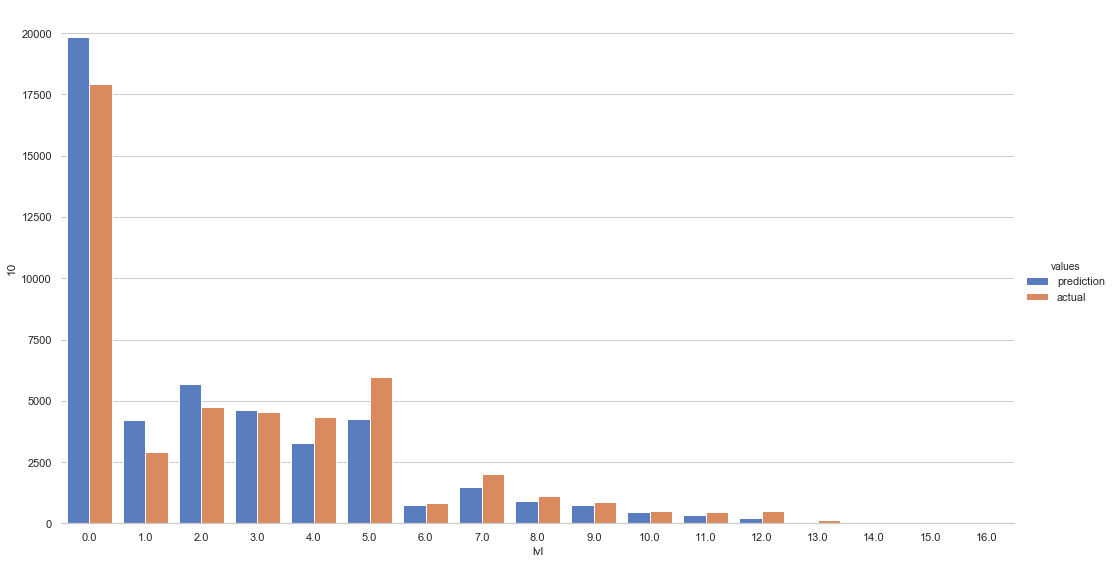

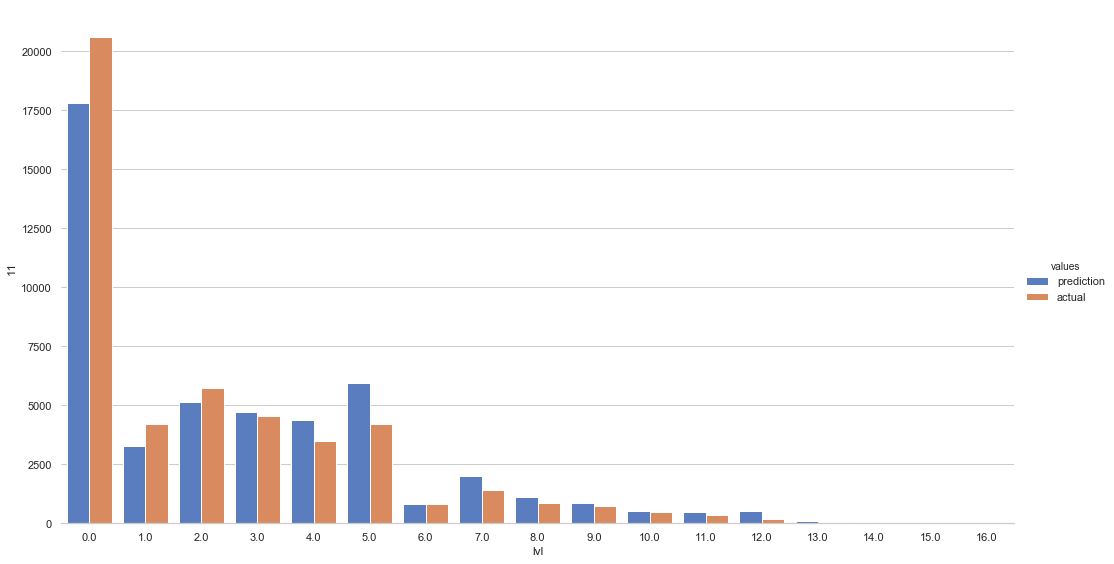

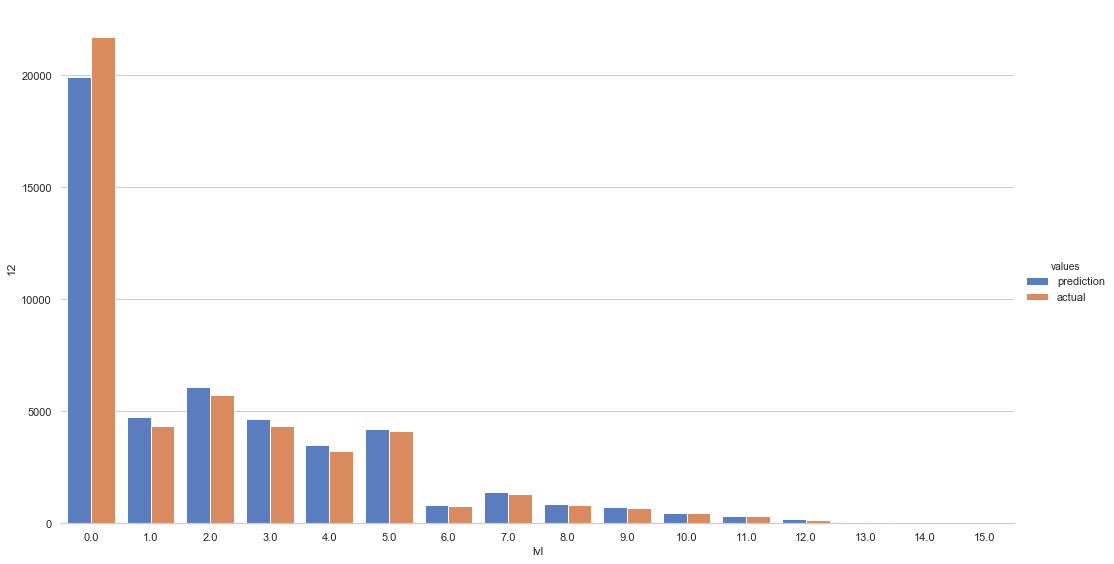

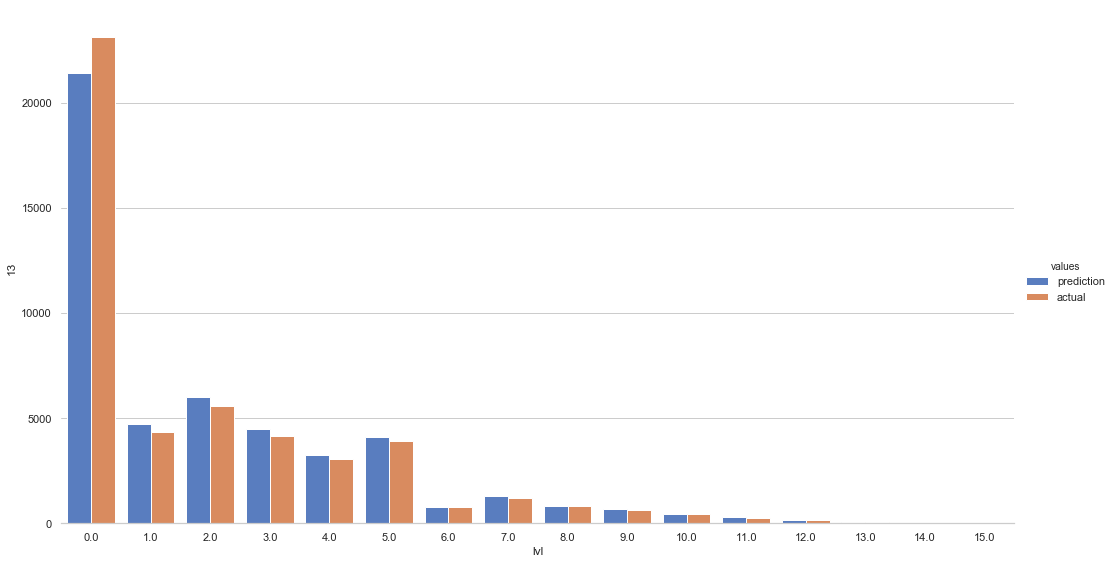

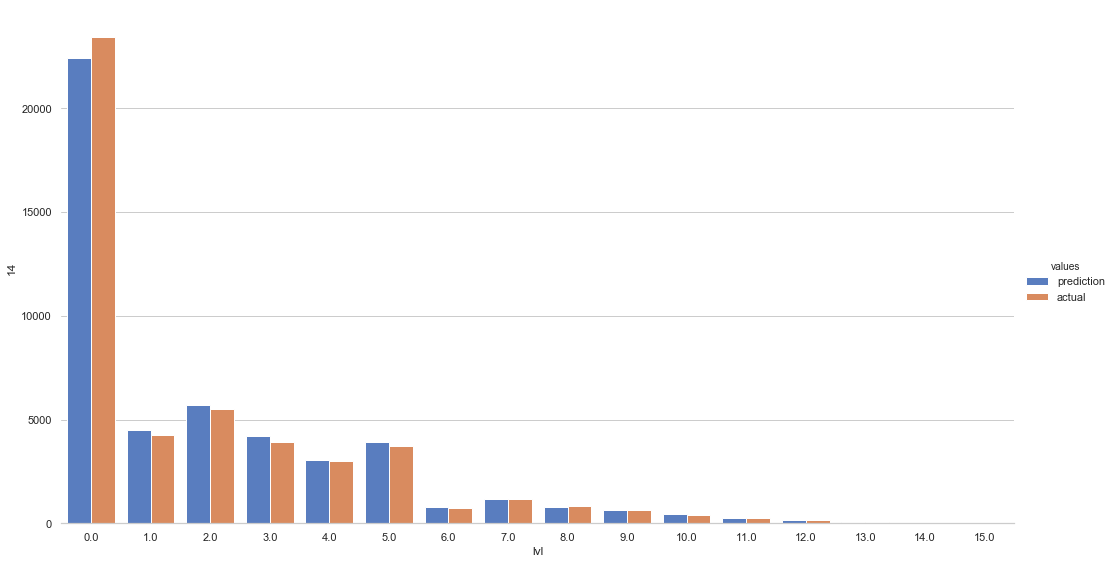

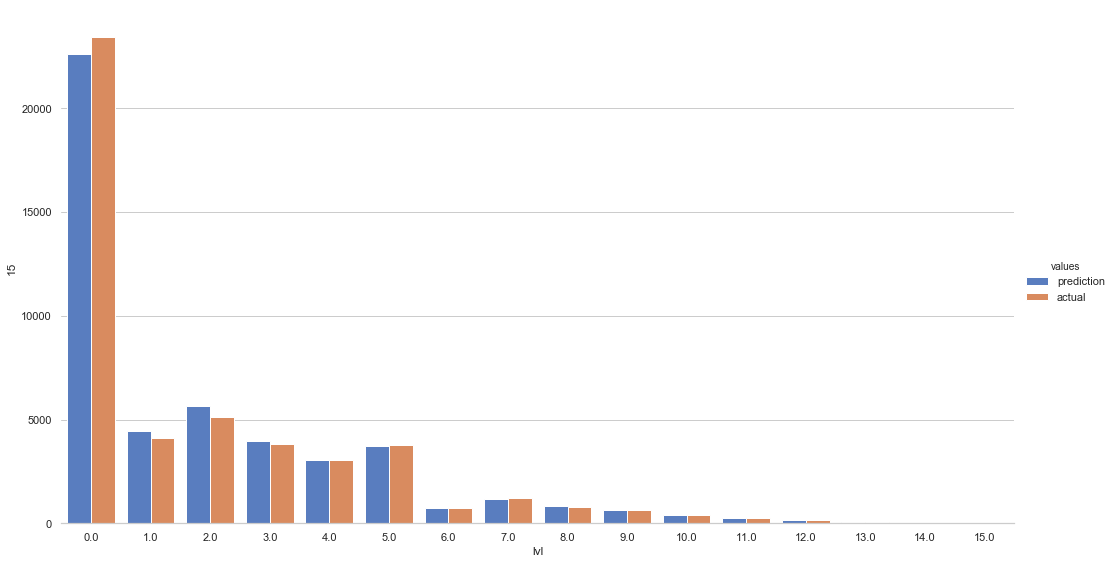

In [13]:
%%time
mean_error = []
df_mean = pd.DataFrame(columns=['LVL_mean'])
for camp in range(3,16):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    p = val['prev_level'].values

    error = rmsle(val['LVL'].values, p)
    plot_difference(val['prev_level'], val['LVL'], camp)
    print('CAMP %d - Accuracy %.5f' % (camp, error))
    mean_error.append(error)

print('Mean Accuracy = %.5f' % np.mean(mean_error))

CAMP 3 - Error 0.97048
CAMP 4 - Error 0.97678
CAMP 5 - Error 0.97904
CAMP 6 - Error 0.96326
CAMP 7 - Error 0.97480
CAMP 8 - Error 0.96150
CAMP 9 - Error 0.98090
CAMP 10 - Error 0.96242
CAMP 11 - Error 0.97654
CAMP 12 - Error 0.98639
CAMP 13 - Error 0.98896
CAMP 14 - Error 0.98815
CAMP 15 - Error 0.98641
Mean Error = 0.97659
Wall time: 4min 31s


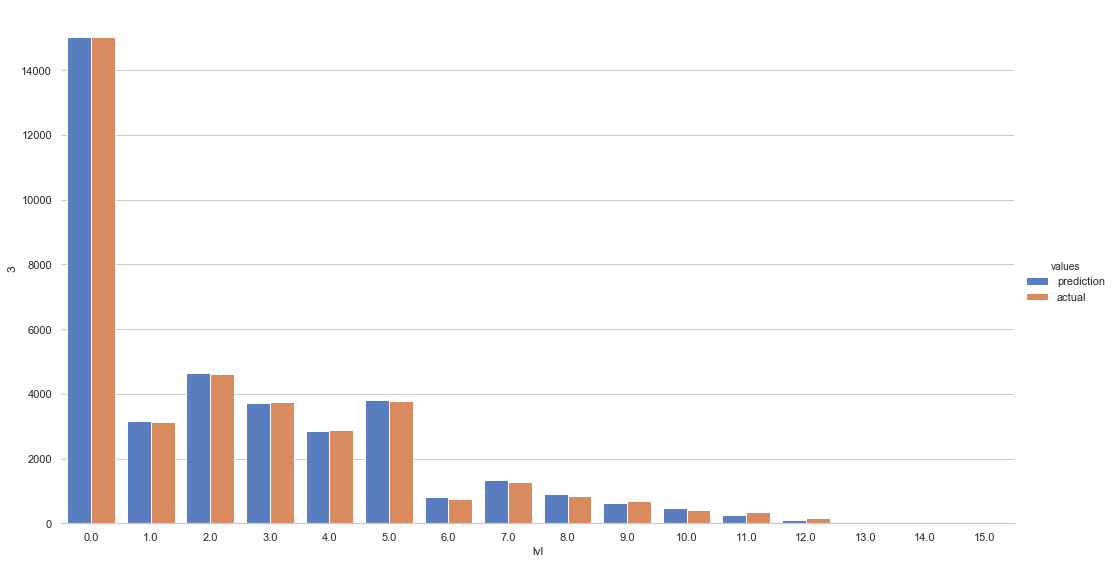

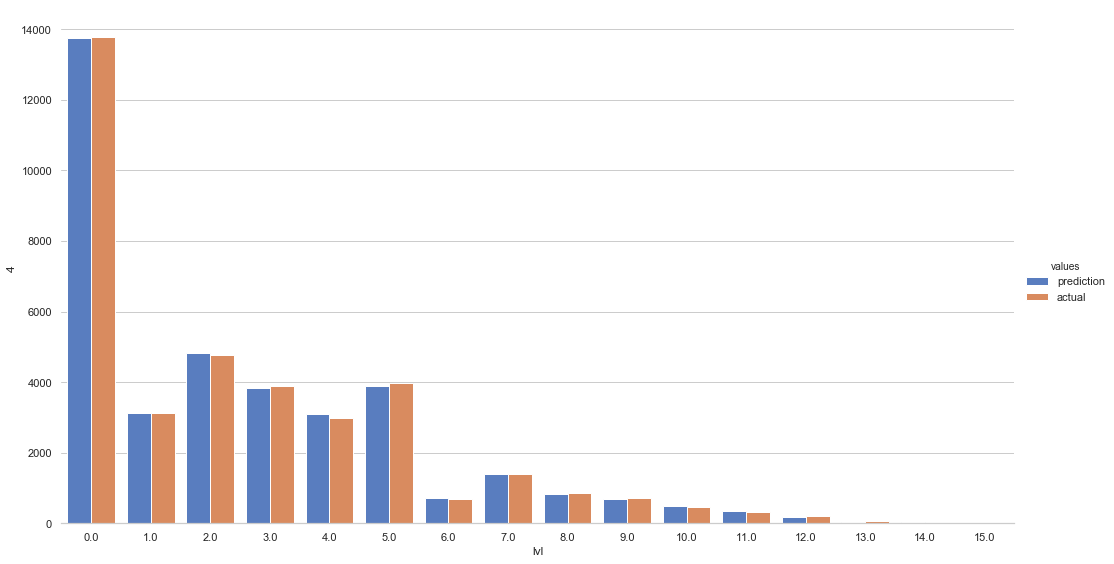

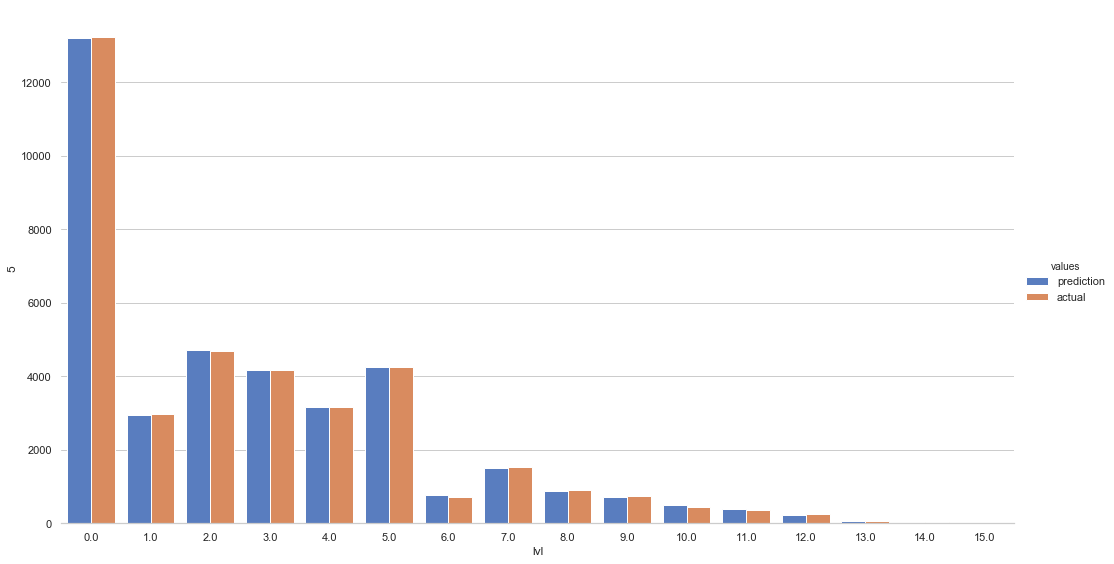

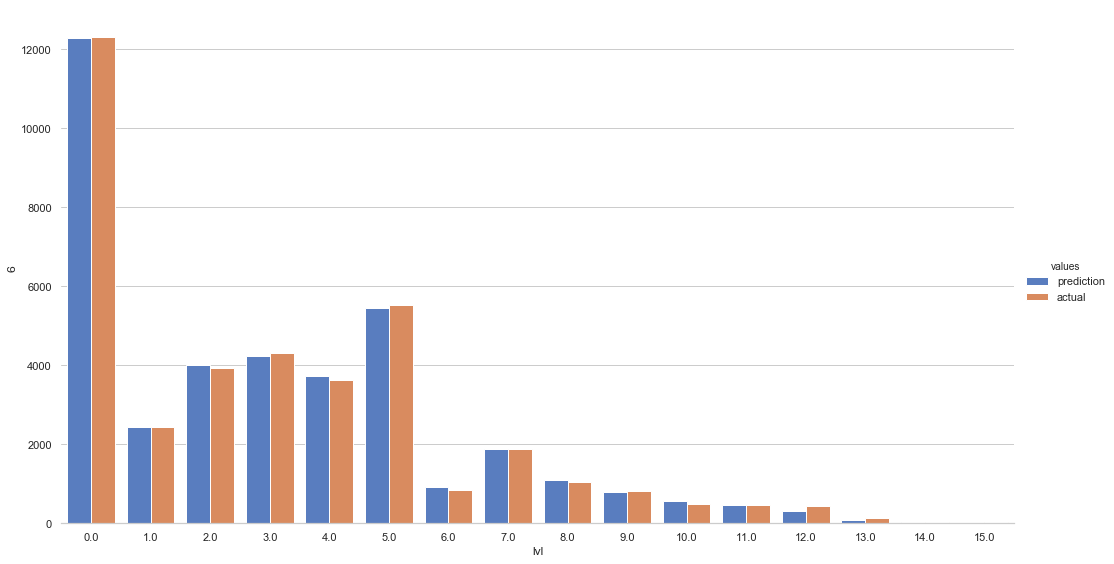

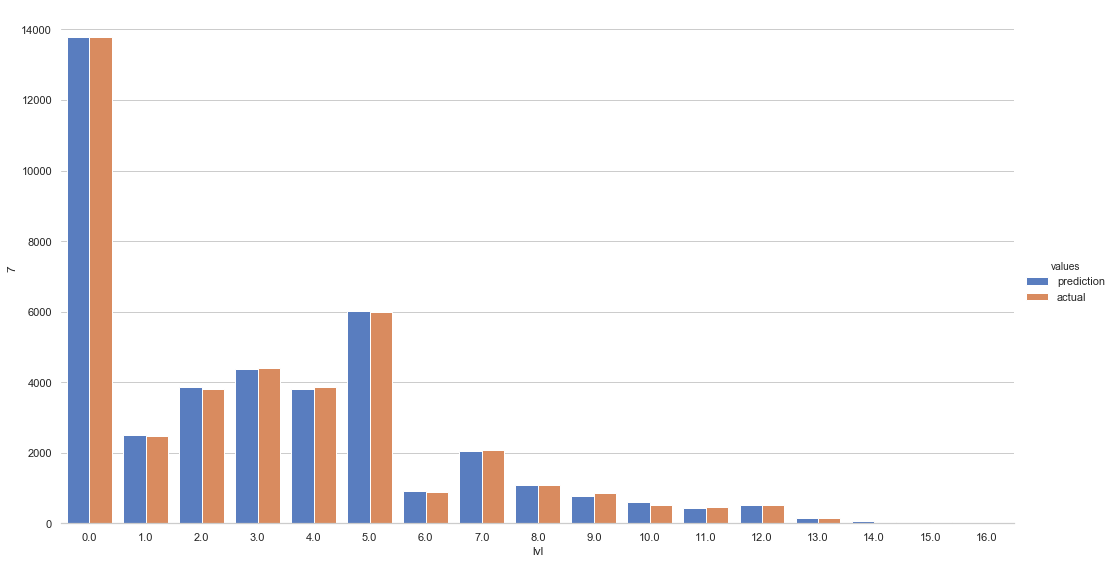

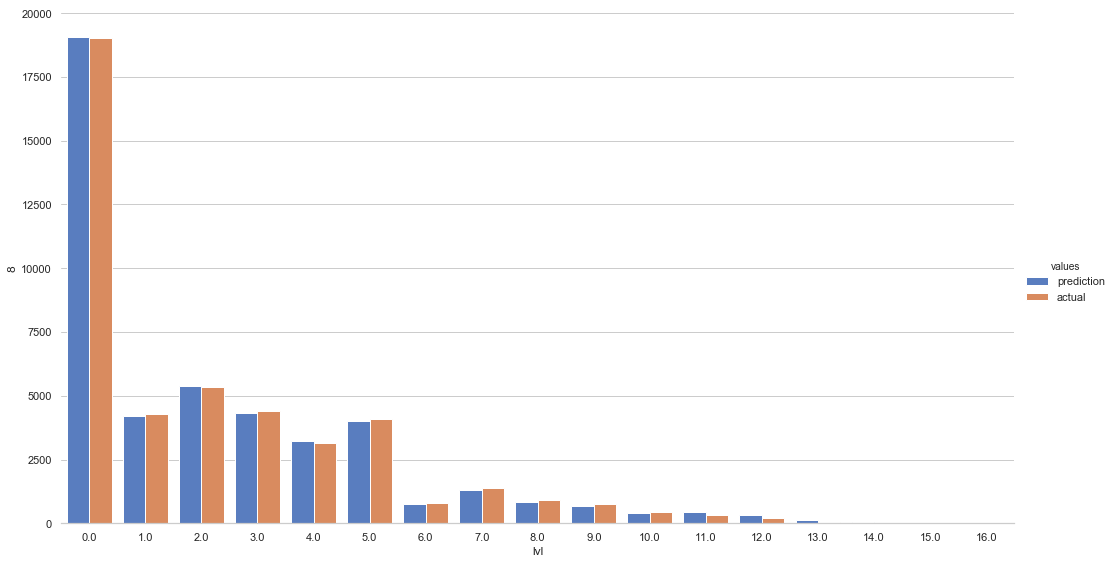

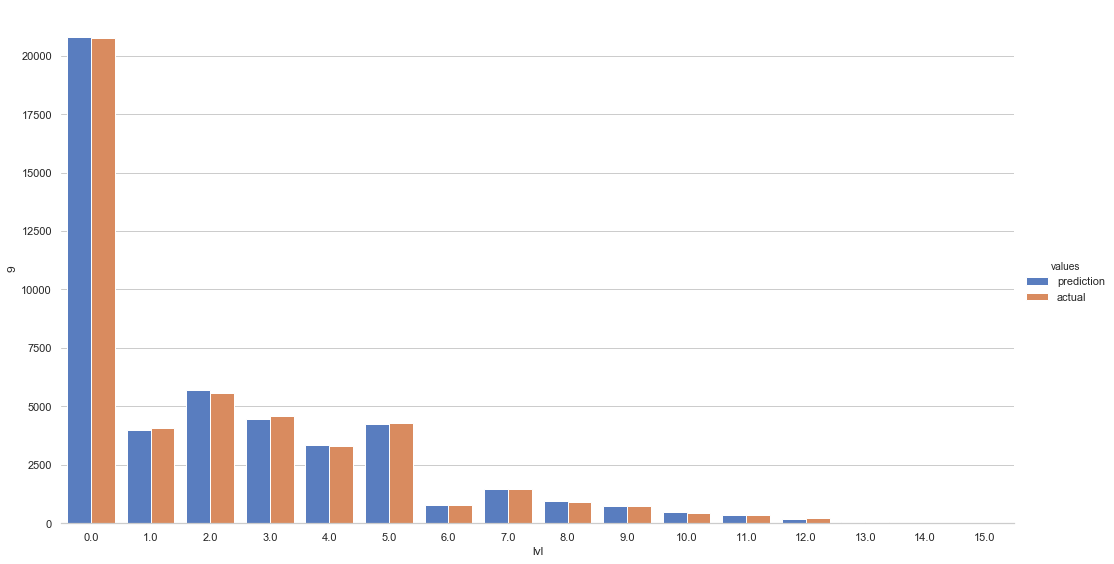

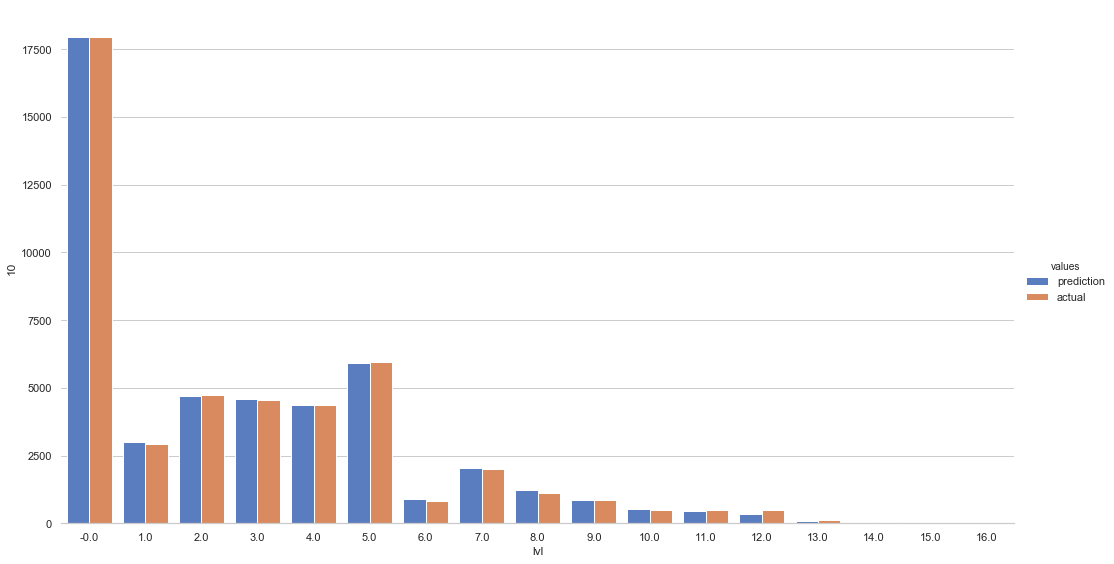

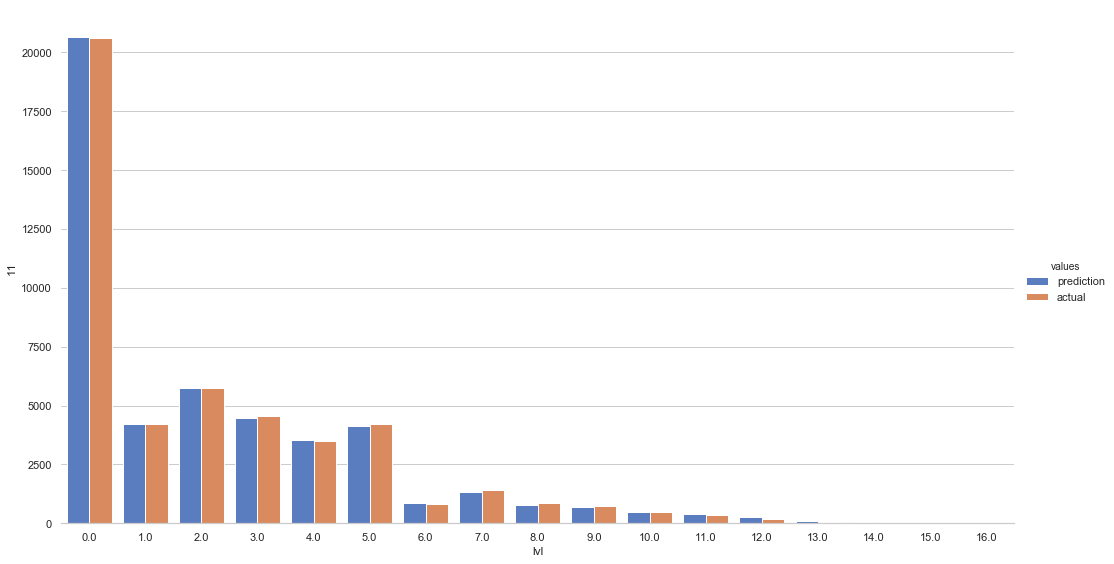

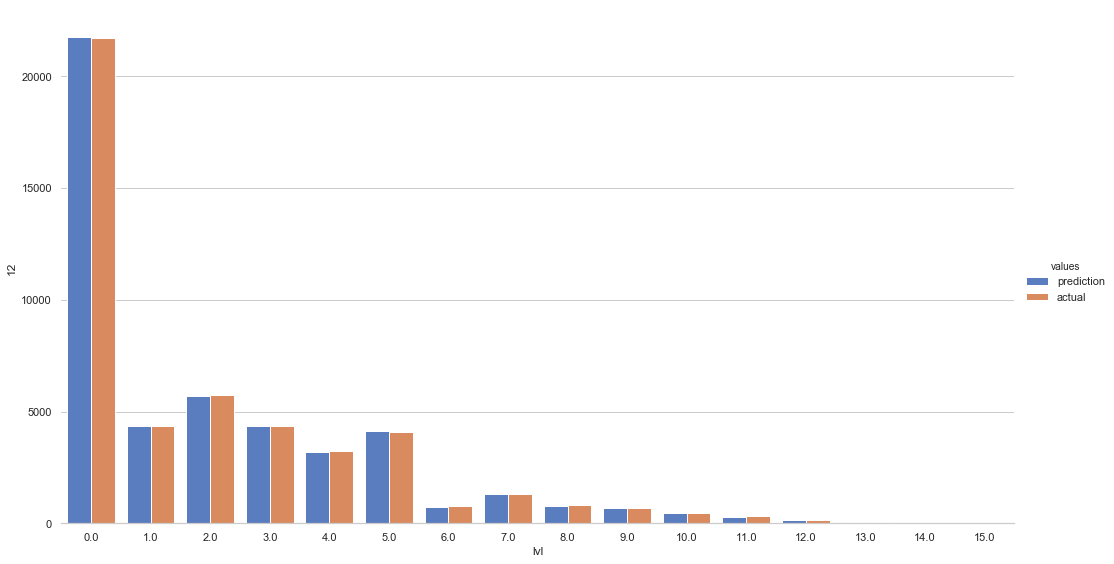

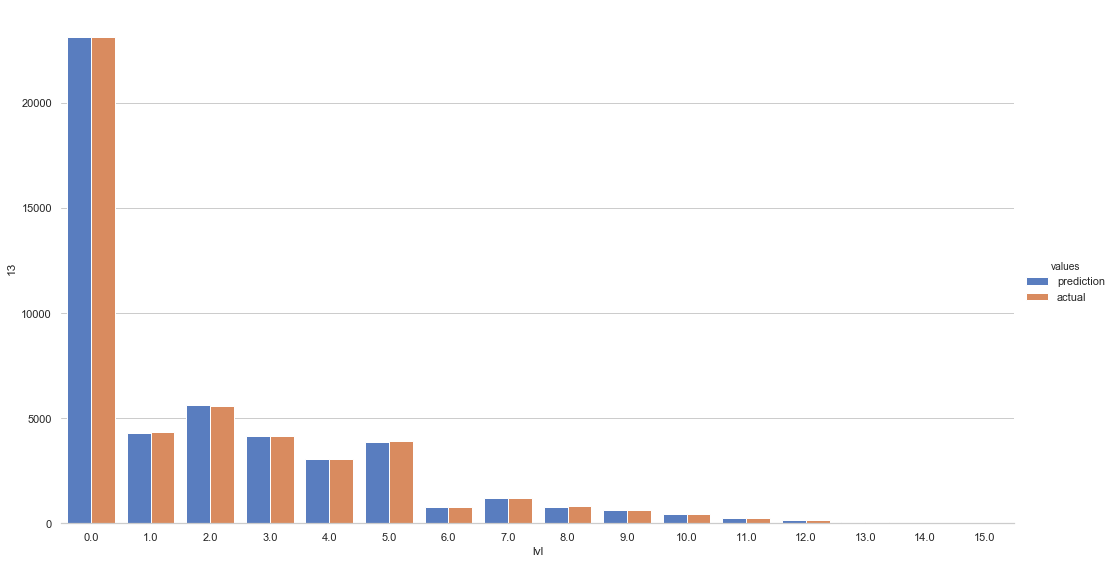

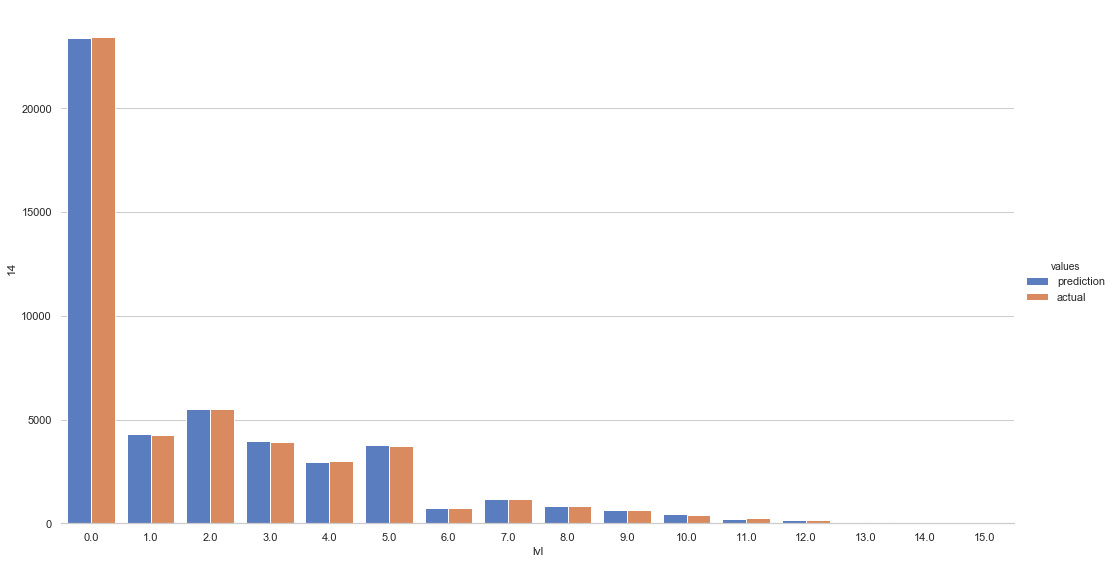

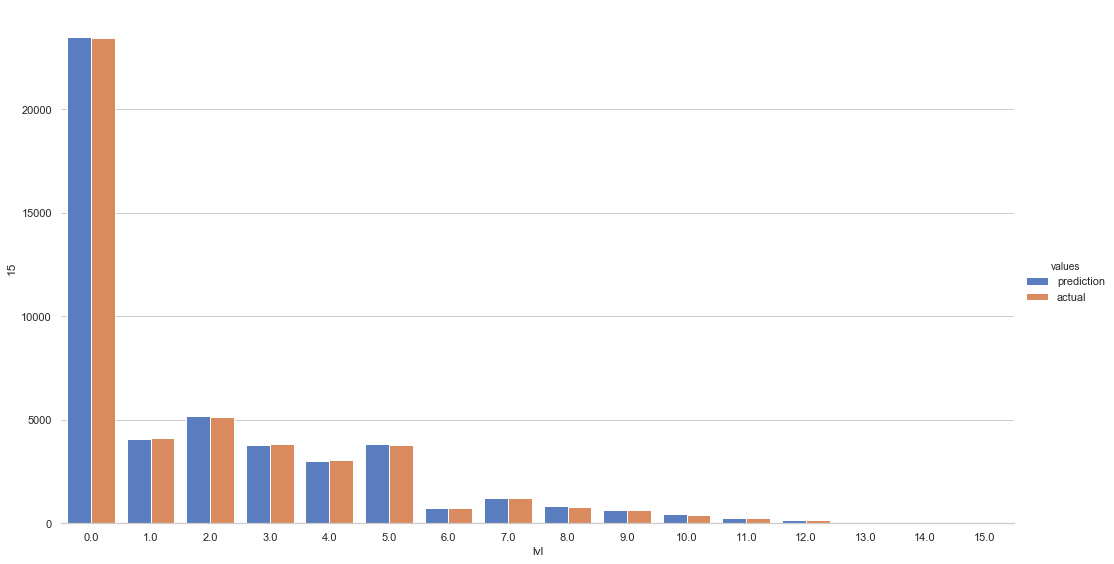

In [15]:
%%time
mean_error = []
for camp in range(3,16):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    xtr, xts = train.drop(['LVL'], axis=1), val.drop(['LVL'], axis=1)
    ytr, yts = train['LVL'].values, val['LVL'].values
    
    mdl = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    mdl.fit(xtr, np.log1p(ytr))

    p = np.expm1(mdl.predict(xts))
    p = np.rint(p)
    predict = pd.Series(p)
    plot_difference(predict, val['LVL'], camp)
    error = rmsle(yts, p)
    print('CAMP %d - Accuracy %.5f' % (camp, error))
    mean_error.append(error)
print('Mean Accuracy = %.5f' % np.mean(mean_error))



In [ ]:
%%time
mean_error = []
for camp in range(3,16):
    train = data2[data2['CAMP'] < camp]
    val = data2[data2['CAMP'] == camp]
    
    xtr, xts = train.drop(['LVL'], axis=1), val.drop(['LVL'], axis=1)
    ytr, yts = train['LVL'].values, val['LVL'].values
    
    mdl = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    mdl.fit(xtr, ytr)
    

    p = mdl.predict(xts)
    p = np.rint(p)
    predict = pd.Series(p)
    plot_difference(predict, val['LVL'], camp)
    error = rmsle(yts, p)
    print('CAMP %d - Accuracy %.5f' % (camp, error))
    mean_error.append(error)
print('Mean Accuracy = %.5f' % np.mean(mean_error))

CAMP 3 - Accuracy 0.97358
CAMP 4 - Accuracy 0.98711


KeyboardInterrupt: 